## Running experiments for May6th meeting

In [13]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [3]:
def runNAgents(function, runs, store=False, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRooms-Goal-9', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [4]:
class DQN():
    def __init__(self, weights_loc, game='FourRooms-Goal-9'):
        config = Config()
        config.game = game
        config.task_fn = lambda: Task(config.game)
        config.eval_env = config.task_fn()
        self.network = VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
        self.network.load_state_dict(torch.load(weights_loc))
    
agents = []
for i in tqdm(range(104)):
    agents.append(DQN('storage/DQN-FourRooms-Goal-'+str(i)+'.weights'))

In [62]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=()) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(0.3, 0.3, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 2e5
    config.async_actor = False
    
    agent = avDSRAgent(config, agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [63]:
avdsr = avdsr_feature(game='FourRooms-Goal-9', agents=agents)

2020-05-03 03:52:59,252 - root - INFO: steps 0, 174762666.67 steps/s
2020-05-03 03:53:00,671 - root - INFO: steps 1000, 706.84 steps/s
2020-05-03 03:53:02,021 - root - INFO: steps 2000, 742.79 steps/s
2020-05-03 03:53:03,244 - root - INFO: steps 3000, 820.13 steps/s
2020-05-03 03:53:04,474 - root - INFO: steps 4000, 816.18 steps/s
2020-05-03 03:53:05,769 - root - INFO: steps 5000, 774.28 steps/s
2020-05-03 03:53:07,153 - root - INFO: steps 6000, 726.52 steps/s
2020-05-03 03:53:09,139 - root - INFO: steps 7000, 504.73 steps/s
2020-05-03 03:53:11,001 - root - INFO: steps 8000, 540.86 steps/s
2020-05-03 03:53:12,614 - root - INFO: steps 9000, 621.14 steps/s
2020-05-03 03:53:14,099 - root - INFO: steps 10000, 675.38 steps/s
2020-05-03 03:53:15,649 - root - INFO: steps 11000, 646.98 steps/s
2020-05-03 03:53:17,134 - root - INFO: steps 12000, 675.07 steps/s
2020-05-03 03:53:18,903 - root - INFO: steps 13000, 566.78 steps/s
2020-05-03 03:53:20,767 - root - INFO: steps 14000, 538.03 steps/s
20

2020-05-03 03:57:03,514 - root - INFO: steps 123000, 262.38 steps/s
2020-05-03 03:57:06,753 - root - INFO: steps 124000, 309.21 steps/s
2020-05-03 03:57:10,014 - root - INFO: steps 125000, 307.75 steps/s
2020-05-03 03:57:11,955 - root - INFO: steps 126000, 517.77 steps/s
2020-05-03 03:57:13,700 - root - INFO: steps 127000, 577.01 steps/s
2020-05-03 03:57:17,618 - root - INFO: steps 128000, 255.55 steps/s
2020-05-03 03:57:19,367 - root - INFO: steps 129000, 574.24 steps/s
2020-05-03 03:57:21,417 - root - INFO: steps 130000, 488.58 steps/s
2020-05-03 03:57:23,991 - root - INFO: steps 131000, 389.14 steps/s
2020-05-03 03:57:26,656 - root - INFO: steps 132000, 377.57 steps/s
2020-05-03 03:57:28,153 - root - INFO: steps 133000, 669.74 steps/s
2020-05-03 03:57:30,118 - root - INFO: steps 134000, 510.03 steps/s
2020-05-03 03:57:31,593 - root - INFO: steps 135000, 679.78 steps/s
2020-05-03 03:57:33,254 - root - INFO: steps 136000, 603.63 steps/s
2020-05-03 03:57:35,222 - root - INFO: steps 137

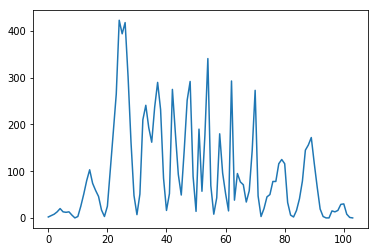

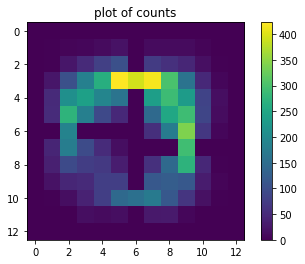

In [64]:
state = np.zeros(10000)
for i in range(10000):
    state[i] = np.argmax(avdsr.replay.data[i][0])
counts = np.zeros(104)
for i in range(10000):
    counts[int(state[i])] += 1
plt.plot(counts), plt.show()
visualize_vector(counts, title='plot of counts')

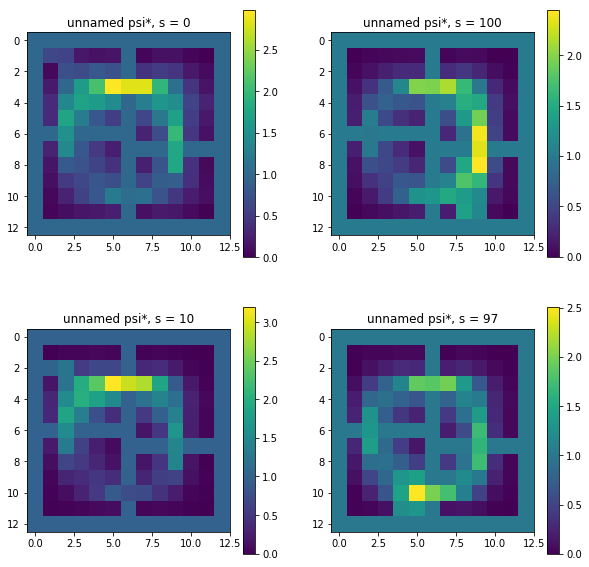

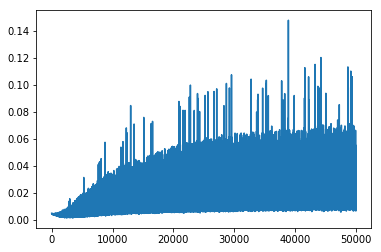

In [65]:
sanity_psi(avdsr)
plt.show()
plt.plot(avdsr.loss_vec)

In [66]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [67]:
r_dsr_init_dqns_0 = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr) 
# r_dsr_init_dqns = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr) 
# r_dsr_init_rand = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr)
# r_dqn_base = runNAgents(dqn_feature, runs=5)

2020-05-03 03:59:35,080 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-05-03 03:59:45,232 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-05-03 03:59:53,198 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-05-03 04:00:03,174 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-05-03 04:00:13,690 - root - INFO: steps 20000, episodic_return_test -200.00(0.00)
2020-05-03 04:00:22,162 - root - INFO: steps 25000, episodic_return_test -200.00(0.00)
2020-05-03 04:00:31,834 - root - INFO: steps 30000, episodic_return_test -200.00(0.00)
2020-05-03 04:00:41,019 - root - INFO: steps 35000, episodic_return_test -200.00(0.00)
2020-05-03 04:00:51,641 - root - INFO: steps 40000, episodic_return_test -200.00(0.00)
2020-05-03 04:01:02,445 - root - INFO: steps 45000, episodic_return_test -200.00(0.00)
2020-05-03 04:01:15,781 - root - INFO: steps 50000, episodic_return_test -200.00(0.00)
2020-05-03 04:01:20,115 - root - INFO: steps 0, 

Process AsyncReplay-91:
Process AsyncReplay-89:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/mnt/c/Users/Surya Penmetsa/Desktop/McGill Courses/Thesis/code/DeepRL/deep_rl/component/replay.py", line 144, in run
    sample(cur_cache)
  File "/mnt/c/Users/Surya Penmetsa/Desktop/McGill Courses/Thesis/code/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/mnt/c/Users/Surya Penmetsa/Desktop/McGill Courses/Thesis/code/DeepRL/deep_rl/component/replay.py", line 121, in sample
    batch_data = replay.sample()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = 

In [38]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6))
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = np.interp(np.arange(clip), t, r)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(), plt.show()

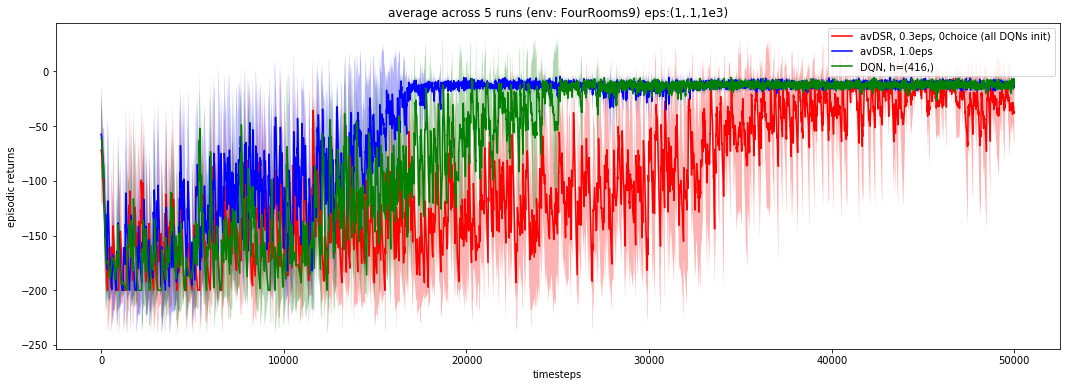

In [68]:
rewards_dict = {'avDSR, 0.3eps, 0choice (all DQNs init)':r_dsr_init_dqns_0,
#                 'avDSR, 0.3eps, 1choice (all DQNs init)': r_dsr_init_dqns,
                'avDSR, 1.0eps': r_dsr_init_rand, 'DQN, h=(416,)': r_dqn_base}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='average across 5 runs (env: FourRooms9) eps:(1,.1,1e3)')

In [61]:
class avDSRActor(BaseActor):
    def __init__(self, config, agents, style='DQN', choice=0):
        """
        style -> depicts the network config of the agent used for exploration.
        choice -> tells how we choose which agent to use for exploration
            0 - at every timestep, we randomly pick and agent and take an eps greedy action
            1 - we choose a DQN every switch_period
        """
        BaseActor.__init__(self, config)
        self.config = config
        self.agents = agents
        self.style = style
        self.choice = choice

        # Parameters to decide which agents should learn
        self.batch_steps = 0
        self.switch_period = 10
        self.agent_id = 0

        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        
        # Choosing which agent for taking actions
        if(self.choice == 0):
            pick = random.choice(self.agents)
        elif(self.choice == 1):
            self.batch_steps += 1
            if(self.batch_steps % self.switch_period == 0): 
                # CHECK: multiprocessing might be screwing something up
                self.agent_id = np.random.randint(len(self.agents))
            pick = self.agents[self.agent_id]
        else:
            raise NameError('Invalid choice config')

        # Find qvalues of the picked agent for the present state
        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick.network(config.state_normalizer(self._state))
            elif(self.style == 'DQN'):
                q_values = pick.network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()

        # Take action based on this estimated q value
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
            
        next_state, reward, done, info = self._task.step([action])
        
        # Also estimate next action
        #############
        if(self.choice == 0):
            pick2 = random.choice(self.agents)
        elif(self.choice == 1):
            pick2 = pick
            
        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick2.network(config.state_normalizer(next_state))
            elif(self.style=='DQN'):
                q_values = pick2.network(config.state_normalizer(next_state))
        q_values = to_np(q_values).flatten()

        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            next_action = np.random.randint(0, len(q_values))
        else:
            next_action = np.argmax(q_values)
        
        entry = [self._state[0], action, reward[0], next_state[0], next_action, int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class avDSRAgent(BaseAgent):
    def __init__(self, config, agents, style='DQN'):
        """
        agents -> list of agents whose actions we need to consider.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []

        self.replay = config.replay_fn()
        self.actor = avDSRActor(config, agents, style)

        self.network = config.network_fn()
        self.network.share_memory()
        self.optimizer = config.optimizer_fn(self.network.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size) # Need to make this size bigger

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, next_action, done, info in transitions:
#             self.record_online_return(info)
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, next_action, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Getting samples from buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, next_actions, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Estimate targets
            with torch.no_grad():
                _, psi_next, _ = self.network(next_states)

            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                next_actions = tensor(next_actions).long()
                psi_next = psi_next[self.batch_indices, next_actions, :] # TODO: double check dims here

            terminals = tensor(terminals)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            phi, psi, _ = self.network(states)
            psi_next.add_(phi) # TODO: double chec this

            # Computing estimates
            actions = tensor(actions).long()
            psi = psi[self.batch_indices, actions, :]
            
            
#             loss_psi = (psi_next - psi).pow(2).mul(0.5).mean(0)
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()

            loss = loss_psi
            
            total_loss = loss.mean()
            self.loss_vec.append(total_loss.item())
            self.loss_psi_vec.append(total_loss.item())
            
            
            self.optimizer.zero_grad()
#             loss.backward(torch.ones(loss.shape))
            loss.backward()

            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

            with config.lock:
                self.optimizer.step()